In [2]:
import data.dataset as dataset

from models.model import HybridNet
from utils.anchors import Anchor
from utils.labels import get_detection_labels
from utils.labels import decode_detection_output
import torch
import torchvision
import numpy as np
import tqdm
import cv2
from loss.detection_loss import DetLoss
from loss.segmentation_loss import SegLoss
import matplotlib.pyplot as plt
import matplotlib.patches as patches



In [3]:
detection_class_num = 8
img_size = (375, 1242)
detection_datset = dataset.DetectionDataset()
segment_dataset = dataset.SegmentDataset()
anchor_generator = Anchor(img_size)


In [4]:
class DetectionLabelDataset(torch.utils.data.Dataset):
    
    def __init__(self) -> None:
        super().__init__()
        self.detection_datset = dataset.DetectionDataset()
        self.cache = {}
        self.anchor_generator = Anchor(img_size)

    def __getitem__(self, idx):
        if idx not in self.cache:
            sample = self.detection_datset[idx]
            img, label = sample
            c, h, w = img.size()
            scale_h = img_size[0] / h
            scale_w = img_size[1] / w
            scale = torch.tensor([1, scale_w, scale_h, scale_w, scale_h])
            label = label * scale
            img = torchvision.transforms.Resize(img_size)(img)
            labels = []
            for anchor in self.anchor_generator.anchors_list[-6:]:
                label_ = get_detection_labels(label, anchor)
                labels.append(label_)

            labels = torch.concat(labels, dim=0)
            self.cache[idx] = (img, labels)
        return self.cache[idx]
        
    def __len__(self):
        return len(self.detection_datset)

detection_datset = DetectionLabelDataset()

In [5]:
img_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(512, interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
)

def detection_rescale(X):
    img_batch = []
    label_batch = []
    for img, label in X:
        c, h, w = img.size()
        scale_h = h / 375
        scale_w = h / 1242
        scale = torch.tensor([1, scale_w, scale_h, scale_w, scale_h])
        label = label * scale
        img = torchvision.transforms.Resize((375,1242))(img)
        img_batch.append(img)
        labels = []
        for anchor in anchor_generator.anchors_list[-6:]:
            label_ = get_detection_labels(label, anchor)
            labels.append(label_)

        labels = torch.concat(labels, dim=0)
        label_batch.append(labels)
    return torch.stack(img_batch,dim=0), torch.stack(label_batch,dim=0)


from torch.utils.data import Subset
def segmentation_rescale(X):
    img_batch = []
    label_batch = []
    for img, label in X:
        img = img_transform(img)
        label = img_transform(label)
        img_batch.append(img)
        label_batch.append(label)
    return torch.stack(img_batch,dim=0), torch.stack(label_batch,dim=0)

# detection_datset = Subset(detection_datset, np.arange(100))
# segment_dataset = Subset(segment_dataset, np.arange(100))
detection_dataloader = torch.utils.data.DataLoader(detection_datset, shuffle=True, batch_size=8)
segment_dataloader = torch.utils.data.DataLoader(segment_dataset, shuffle=True, batch_size=8, collate_fn = segmentation_rescale)

torch.save(detection_dataloader, "detection_dataset.pt")
torch.save(segment_dataloader, "segment_dataset.pt")


In [5]:
# visualization detection label

anchors = list()
for anchor in anchor_generator.anchors_list[-6:]:
    anchor = anchor.reshape(-1,4)
    anchors.append(anchor)

anchors = torch.concatenate(anchors, 0)

batch_sample = next(iter(detection_dataloader))

fig, axes = plt.subplots(2,2)
fig.set_size_inches(26,8)
for i in range(4):
    sample_img = batch_sample[0][i]
    sample_box = batch_sample[1][i]
    sample_img = torch.permute(sample_img, (1,2,0))
    axes[i%2, i//2].imshow(sample_img)
    axes[i%2, i//2].axis('off')
    sample_cls = sample_box[:,0]
    object_ids = torch.where(sample_cls>0)
    sample_box = sample_box[:,1:]
    decoded_sample_box = decode_detection_output(anchors, sample_box)
    for ids in object_ids[0]:
        bbox = decoded_sample_box[ids]
        axes[i%2, i//2].add_patch(
            patches.Rectangle(
                (bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2),
                bbox[2], bbox[3],
                edgecolor='red',
                facecolor='none'
            )
        )


KeyboardInterrupt: 

In [ ]:
net = HybridNet(128, anchor_generator.anchor_nums, detection_class_num)
net = net.to('cuda')

In [ ]:
# run segmentation training
import tqdm

def train_segmentation_task(net, segment_dataloader):
    loss = SegLoss()
    optimizer = torch.optim.Adam(net.parameters())
    pbar = tqdm.tqdm(total = len(segment_dataloader))
    acc_accum = 0
    acc_size = 0
    for batch in segment_dataloader:
        X, y = batch
        X, y = X.to('cuda'), y.to('cuda')
        y = torch.where(y==7, 1, 0)
        y = y.float()
        X = X / 255.0
        pred = net(X)
        pred_seg, pred_det= pred
        loss_score, acc = loss(pred_seg, y)
        optimizer.zero_grad()
        loss_score.backward()
        optimizer.step()
        acc_size += y.size()[0] * y.size()[1] * y.size()[2] * y.size()[3]
        acc_accum += acc.sum()
        acc = (acc_accum / acc_size).item()
        pbar.set_description(f"loss:{loss_score:.3f}, acc:{acc*100:.3f}%")
        pbar.update()
    pbar.close()


In [ ]:
# run detection training 

def train_detection_task(net, detection_dataloader):
    loss = DetLoss(detection_class_num)
    optimizer = torch.optim.Adam(net.parameters())

    pbar = tqdm.tqdm(total = len(detection_dataloader))
    for batch in detection_dataloader:
        X, y = batch
        X, y = X.to('cuda'), y.to('cuda')
        X = X / 255.0
        pred = net(X)
        pred_seg, pred_det = pred
        all_loss,cls_loss,box_loss = loss(pred_det, y)
        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
        pbar.set_description(f"loss:{all_loss:.3f}, cls_loss{cls_loss:.3f}, box_loss{box_loss:.3f}")
        pbar.update()
    pbar.close()


In [ ]:
# multi task learning
for i in range(10):
        train_segmentation_task(net, segment_dataloader)
        train_detection_task(net, detection_dataloader)
        torch.save(net, f'trained_model_{i}.pth')

loss:0.065, acc:97.806%:  38%|███▊      | 5/13 [00:47<01:15,  9.49s/it]


KeyboardInterrupt: 

(tensor([165595, 165596, 165597, 165616, 165617, 166075, 166076, 166551, 166552,
        166556, 167030, 167031, 167032, 167036, 169397, 169398, 169416, 169417,
        169418, 169896, 169897, 170392, 170396, 170397, 170872, 170876, 170877,
        188295, 188296, 188297, 188535, 188536, 188537, 190456, 190457, 190696,
        190697, 191395, 191396, 191635, 191636, 191637, 191875, 191876, 192355,
        192356, 192357, 192595, 192596, 192597, 192832, 192835, 192836, 192837,
        193072, 193075, 193076, 193077, 193637, 193656, 193657, 193658, 193777,
        194470, 194471, 194590, 194591, 195071, 195072, 195077, 195197, 195530,
        195531, 195532, 195645, 196107, 196357, 196377]),)
tensor([165595, 165596, 165597, 165617, 166075, 166076, 166077, 166550, 166551,
        166552, 166555, 166556, 167030, 167031, 167032, 167036, 167037, 169396,
        169397, 169398, 169411, 169412, 169416, 169417, 169897, 170390, 170391,
        170392, 170395, 170396, 170397, 170871, 170872, 1708

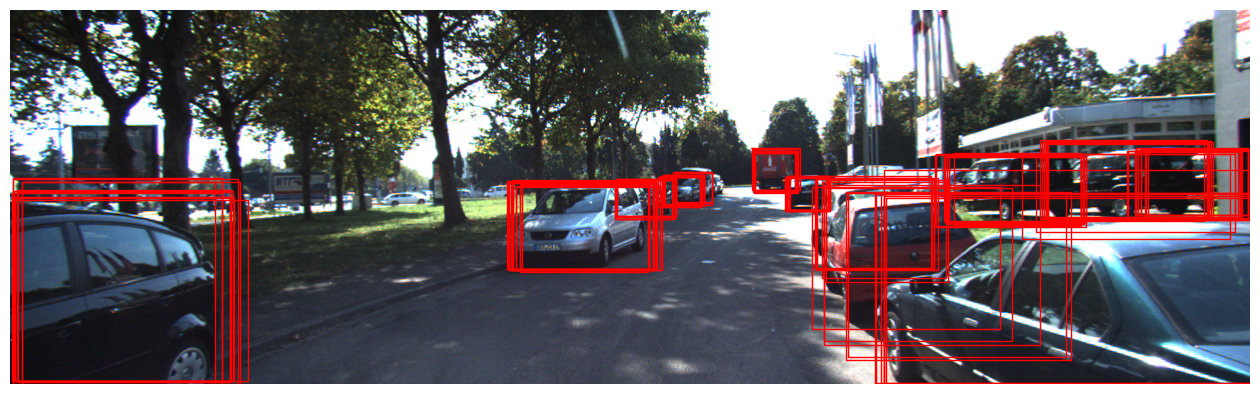

In [ ]:
# visualize detection result
net = torch.load('./trained_model_19.pth')
anchors = list()
for anchor in anchor_generator.anchors_list[-6:]:
    anchor = anchor.reshape(-1,4)
    anchors.append(anchor)

anchors = torch.concatenate(anchors, 0)
X, y = next(iter(detection_dataloader))
X = X.to('cuda')
X = X / 255.0
preds = net(X)

sample_idx = 3
p_list = list()
for p in preds[1]:
    p = torch.permute(p, (0,3,2,1))
    p = p[sample_idx]
    p = p.reshape(-1, 4 + 1 + detection_class_num)
    p_list.append(p)

y = y[sample_idx,:]
p_list = torch.concatenate(p_list, 0)
p_list = p_list.to('cpu')
anchors = anchors.to('cpu')
cls_output = p_list[:,:-4]
box_output = p_list[:,-4:]
box_output = decode_detection_output(anchors, box_output)
y[:,1:] = decode_detection_output(anchors, y[:,1:])
cls_output = torch.softmax(cls_output,1)
cls_max = torch.max(cls_output, 1)
cls_max_ids = torch.where(cls_max[1] > 0)
sample = X[sample_idx]
sample = sample.permute(1,2,0)

fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plt.axis('off')
pos_size = torch.where(y[:, 0] > 0)
print(pos_size)
print(cls_max_ids[0])
# for i in range(y.size()[0]):
#     if y[i][0] > 0:
#         bb = box_output[i].to('cpu')
#         bb = bb.detach().numpy()
#         ax.add_patch(
#             patches.Rectangle(
#                 (bb[0] - bb[2] / 2, bb[1] - bb[3]/2),
#                 bb[2], bb[3],
#                 edgecolor='blue',
#                 facecolor='none'
#             )
#         )
for ids in cls_max_ids[0]:
    if cls_max[0][ids] > 0.5:
        bb = box_output[ids].to('cpu')
        bb = bb.detach().numpy()
        ax.add_patch(
            patches.Rectangle(
                (bb[0] - bb[2] / 2, bb[1] - bb[3]/2),
                bb[2], bb[3],
                edgecolor='red',
                facecolor='none'
            )
        )
ax.imshow(sample.to('cpu').numpy())

In [ ]:

# torch.save(detection_dataloader, 'detection_dataset.pt')
# torch.save(segment_dataloader, 'segmentation_dataset.pt')

# net = torch.save(net, 'trained_model.pth')
# net = torch.load("trained_model.pth")

# import matplotlib.pyplot as plt
# sample = next(iter(segment_dataloader))
# sample = sample[0]
# sample = sample.to('cuda')
# sample = sample.to(torch.float32)
# output = net(sample)
# output = output[1]
# output = output.to('cpu')
# output = torch.permute(output, (0,2,3,1))
# output = output.detach().numpy()

# fig, axes = plt.subplots(3,3)
# fig.set_size_inches(16,16)

# sample = sample.to('cpu').to(torch.uint8)
# sample = torch.permute(sample, (0,2,3,1))
# for i in range(8):
#     axes[i//3, i%3].imshow(sample[i])

# fig, axes = plt.subplots(3,3)
# for i in range(8):
#     axes[i//3, i%3].imshow(output[i])

